In [1]:
# Install Konlpy and Mecab
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2023-04-05 12:21:29--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-04-05 12:21:29--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucef104f45a79ad8ce926065377d.dl.dropboxusercontent.com/cd/0/get/B5nM-2ZkMSECfxt1tbxdbdB02iQuldIwBpn6a74rOiWfWxcMGs53WHP1Hx13yXn4RGsL-Gzkam5cHJrVsiJaxZU1aO6CSRBhZy1Q1rlVJvdx_AI11j5noatKktOO5lCLW0r1BgmCOx46Dm478q1a-o8ryxka5LyQoaDNOk9zYY_o2At1SAlonDLJ-uZwEdjG7VQ/file?dl=1# [following]
--2023-04-05 12:21:30--  https://ucef104f45a79ad8ce926065377d.dl.dropboxusercontent.com/cd/0/get/B5nM-2ZkMSEC

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
from tqdm.notebook import tqdm
from google.colab import drive
from konlpy.tag import Mecab
tqdm.pandas()

In [3]:
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Side_project/Brand_Monitoring/")

Mounted at /content/drive


# Load Review Data

In [4]:
review = pd.read_csv("main_dictionary.csv")
lexicon_df = review[["review_text", "rating"]].copy()

# Tokenize by Mecab pos tagger

In [5]:
mecab = Mecab()
# Remain Nouns, Verbs, Adjectives, Adverbs
lexicon_pos = ["NNG", "NNP", "VV", "VA", "VCP", "VCN", "MM", "MAG", "XR"]

In [6]:
lexicon_df["words"] = lexicon_df["review_text"].progress_apply(lambda x: [token[0] + "/" + token[1] for token in mecab.pos(x) if token[1] in lexicon_pos])

  0%|          | 0/279411 [00:00<?, ?it/s]

# Probabilistic Score 

In [7]:
corpus = []
for row in lexicon_df["words"].values.tolist():
  corpus += row

In [8]:
gamma = 4
beta = 0.5
corpus_len = len(corpus)
unique_words = list(set(corpus))
dict_rating = [{key: 0 for key in unique_words} for i in range(5)]
word_freq = {key: 0 for key in unique_words}
freq_thresh = 10

def increase_dictionaries(rate_dict, word_freq, word_list):
  for word in word_list:
    rate_dict[word] +=1
    word_freq[word] +=1

In [9]:
# Count number of words for each rating and total frequency of each word
for i, cur_dict in enumerate(dict_rating):
  cur_review = lexicon_df[lexicon_df["rating"] == (i+1)]
  cur_review["words"].apply(lambda x: increase_dictionaries(cur_dict , word_freq, x))

word_freq_filtered = dict(filter(lambda elem:elem[1]>freq_thresh, word_freq.items()))
filter_words = list(word_freq_filtered.keys())
k_dic = len(word_freq_filtered)

In [10]:
word_num = {key: [0,0] for key in filter_words}
# Sigma_{w'}(Sigma_{R_pos}n_{w'r}) / Sigma_{w'}(Sigma_{R_neg}n_{w'r})
pos_sum = 0
neg_sum = 0
# N(total)
total_freq = sum(word_freq_filtered.values())
for word in filter_words:
  # Sigma_{R_pos}n_{wr} / Sigma_{R_neg}n_{wr}
  word_num[word][0] = gamma*dict_rating[4][word] + dict_rating[3][word]
  word_num[word][1] = gamma*dict_rating[0][word] + dict_rating[1][word] + beta*dict_rating[2][word]
  pos_sum += word_num[word][0]
  neg_sum += word_num[word][1]
# P(pos) / P(neg)
p_pos = pos_sum/(pos_sum + neg_sum)
p_neg = neg_sum/(pos_sum + neg_sum)

In [11]:
# p(w|pos), p(w|neg)
p_like = {key: [0,0] for key in filter_words}
p_score = {key: 0 for key in filter_words}
for word in filter_words:
	p_like[word][0] = word_num[word][0]/pos_sum 
	p_like[word][1] = word_num[word][1]/neg_sum
  # p(pos|w) / p(pos|neg)
	p_post_pos = (p_pos * p_like[word][0])/(word_freq_filtered[word]/total_freq)
	p_post_neg = (p_neg * p_like[word][1])/(word_freq_filtered[word]/total_freq)
	p_score[word] = p_post_pos - p_post_neg 

In [12]:
sorted(p_score.items(), key=lambda item: item[1], reverse=False)[:30]

[('최악/NNG', -0.3778414854207104),
 ('욕먹/VV', -0.17802146909245012),
 ('통보/NNG', -0.10443926186757076),
 ('장사/NNG', -0.07668617130136313),
 ('도저히/MAG', -0.05893124494094909),
 ('물탄/NNP', -0.026703220363867575),
 ('연월/NNG', -0.012947015933996386),
 ('허접/NNG', -0.010955167328766169),
 ('반품/NNG', 0.0069134551103863795),
 ('곰팡이/NNG', 0.012947015933996359),
 ('이하/NNG', 0.01884933202155359),
 ('별로/NNG', 0.020345310753422857),
 ('청소/NNG', 0.021910334657532254),
 ('환불/NNG', 0.022786748043833627),
 ('검수/NNG', 0.0305179661301343),
 ('황당/XR', 0.04272515258218795),
 ('질질/MAG', 0.05538445705098444),
 ('불친절/NNG', 0.056966870109583984),
 ('지극히/MAG', 0.06408772887328204),
 ('물엿/NNG', 0.08245204884281893),
 ('방치/NNG', 0.14241717527396003),
 ('번호/NNG', 0.160219322183205),
 ('식초/NNG', 0.16032104873697217),
 ('샙/NNG', 0.18039508868034942),
 ('복불복/NNG', 0.18623784458902468),
 ('닝닝/MAG', 0.1898895670319468),
 ('냉이/NNG', 0.20472468945631755),
 ('속상하/VA', 0.20943702246170598),
 ('본드/NNG', 0.20987794250899375),

## Normalize data ** Not used
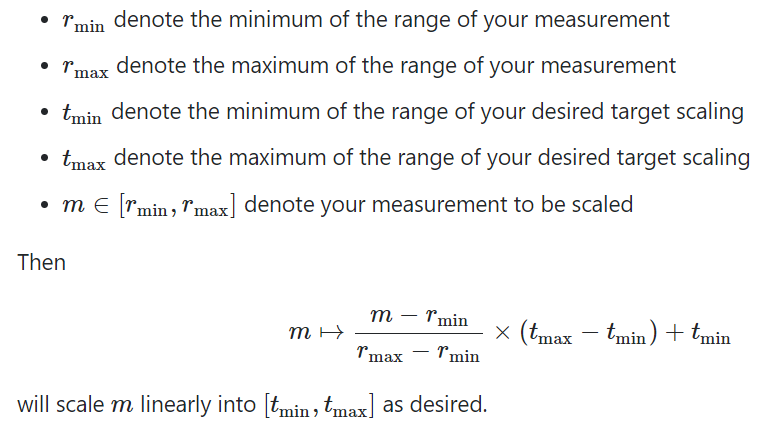

In [13]:
r_min = min(p_score.values())
r_max = max(p_score.values())
t_min = -1
t_max = 1

def linear_normalization(m):
  return ((m-r_min)/(r_max - r_min)) * (t_max - t_min) + t_min

In [14]:
p_score_nor = {k: linear_normalization(v) for k, v in p_score.items()}

In [15]:
sorted(p_score_nor.items(), key=lambda item: item[1], reverse=False)

[('최악/NNG', -1.0),
 ('욕먹/VV', -0.7365900383141764),
 ('통보/NNG', -0.6395913154533845),
 ('장사/NNG', -0.6030061892130858),
 ('도저히/MAG', -0.5796010040956534),
 ('물탄/NNP', -0.5371168582375481),
 ('연월/NNG', -0.5189829327760362),
 ('허접/NNG', -0.5163572060123784),
 ('반품/NNG', -0.4928021426180115),
 ('곰팡이/NNG', -0.48484848484848486),
 ('이하/NNG', -0.4770678386297047),
 ('별로/NNG', -0.47509578544061315),
 ('청소/NNG', -0.4730327144120249),
 ('환불/NNG', -0.4718773946360153),
 ('검수/NNG', -0.4616858237547893),
 ('황당/XR', -0.44559386973180093),
 ('질질/MAG', -0.4289059174116646),
 ('불친절/NNG', -0.42681992337164754),
 ('지극히/MAG', -0.4174329501915709),
 ('물엿/NNG', -0.3932244404113734),
 ('방치/NNG', -0.31417624521072807),
 ('번호/NNG', -0.2907088122605366),
 ('식초/NNG', -0.2905747126436783),
 ('샙/NNG', -0.26411238825031946),
 ('복불복/NNG', -0.2564102564102565),
 ('닝닝/MAG', -0.2515964240102171),
 ('냉이/NNG', -0.23204022988505768),
 ('속상하/VA', -0.22582826233941866),
 ('본드/NNG', -0.2252470256100022),
 ('차라리/MAG', -0.220

## Visualizaton

<ipython-input-16-b6a406a06419>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(p_score_nor.values()))


<Figure size 640x480 with 0 Axes>

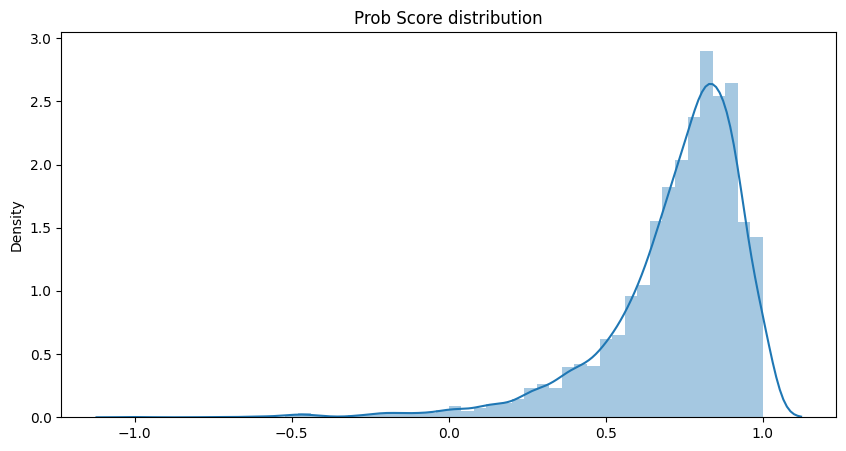

<Figure size 640x480 with 0 Axes>

In [16]:
fig = plt.figure(figsize=(10,5))
sns.distplot(list(p_score_nor.values()))
plt.title("Prob Score distribution")
plt.figure()

# Information Theoretic Score

In [17]:
N = len(lexicon_df) # number of total reviews
N_pos = sum(lexicon_df["rating"] == 4) + sum(lexicon_df["rating"] == 5) # number of positive reviews
N_neg = sum(lexicon_df["rating"] == 1) + sum(lexicon_df["rating"] == 2) + sum(lexicon_df["rating"] == 3) # number of negative reviews

In [18]:
dict_rating = [{key: 0 for key in filter_words} for i in range(5)]
# Save Document Frequencies
df_dict  = {key: 0 for key in filter_words}
# Save Information Scores
it_score = {key: 0 for key in filter_words}

In [19]:
# Calculate relative term frequency for each word in each rate dict
def cal_rtf(word_list, rate_dict):
	r_len = len(word_list)
	for word in word_list:
		rate_dict[word] = rate_dict[word] + (1/r_len)

# Calculate document frequency for each word
def cal_df(word_list, df_dict):
	unique_words = list(set(word_list))
	for word in unique_words:
		df_dict[word] += 1

def do_calculation(word_list, rate_dict, df_dict):
	cal_rtf(word_list, rate_dict)
	cal_df(word_list, df_dict)

In [20]:
# Remain words above threshold
lexicon_df["filtered"] = lexicon_df["words"].progress_apply(lambda x :list(filter(lambda elem:elem in filter_words, x)))

  0%|          | 0/279411 [00:00<?, ?it/s]

In [21]:
# Calculate rtf & df from each review
for i, cur_dict in enumerate(dict_rating):
  cur_review = lexicon_df[lexicon_df["rating"] == (i+1)]
  cur_review["filtered"].progress_apply(lambda x : do_calculation(x, cur_dict, df_dict))

  0%|          | 0/1031 [00:00<?, ?it/s]

  0%|          | 0/1383 [00:00<?, ?it/s]

  0%|          | 0/9409 [00:00<?, ?it/s]

  0%|          | 0/30056 [00:00<?, ?it/s]

  0%|          | 0/237532 [00:00<?, ?it/s]

In [22]:
for word in filter_words:
  # Calculate brtf(w)
	dict_rating[0][word] = dict_rating[0][word]/N_neg * N
	dict_rating[1][word] = dict_rating[1][word]/N_neg * N
	dict_rating[2][word] = dict_rating[2][word]/N_neg * N
	dict_rating[3][word] = dict_rating[3][word]/N_pos * N
	dict_rating[4][word] = dict_rating[4][word]/N_pos * N
  # Calculate pos(w) / neg(w)
	pos = gamma*dict_rating[4][word] + dict_rating[3][word]
	neg = gamma*dict_rating[0][word] + dict_rating[1][word] + beta*dict_rating[2][word]
  # Calculate IDF(W)
	idf =  np.log10(N/(df_dict[word]+1))
  # Calculate Score_IT(w)
	it_score[word] = (pos - neg) * idf 

In [23]:
sorted(it_score.items(), key=lambda item: item[1], reverse=True)[:100]

[('맛있/VA', 31270.49999839043),
 ('좋/VA', 29951.1375773614),
 ('구매/NNG', 25349.50203076407),
 ('선물/NNG', 24848.11981443112),
 ('잘/MAG', 19895.612880582004),
 ('배송/NNG', 19522.460827070376),
 ('먹/VV', 17620.004419976554),
 ('만족/NNG', 17044.005783414097),
 ('감사/NNG', 15055.123420843503),
 ('너무/MAG', 14073.830592090848),
 ('빠르/VA', 13094.523363089844),
 ('한/MM', 12467.688527309263),
 ('포장/NNG', 11195.532446730509),
 ('받/VV', 11183.901692777938),
 ('주문/NNG', 10947.005670588871),
 ('막걸리/NNG', 10587.310327375886),
 ('맛/NNG', 10527.5013294601),
 ('아주/MAG', 10440.145453264053),
 ('최고/NNG', 10127.564579121099),
 ('사용/NNG', 9861.226395033738),
 ('또/MAG', 9493.732237076454),
 ('부드럽/VA', 9134.099688296796),
 ('정말/MAG', 8361.71709886738),
 ('깔끔/XR', 8044.2714530288495),
 ('하/VV', 7550.519581257918),
 ('마시/VV', 7374.2903840855115),
 ('술/NNG', 6627.746494592967),
 ('이/VCP', 6588.883976742705),
 ('꼼꼼/XR', 6531.600717869477),
 ('굿/NNG', 6507.069418313745),
 ('맛나/VA', 6347.665862284455),
 ('항상/MAG', 6304

## Normalize data ** Not used

In [187]:
# Truncate top 75% and 25% to regularize outliers
top_quand = int(len(it_score) * 0.75)
bottowm_quand = int(len(it_score) * 0.25)

top_quan_val = \
sorted(it_score.items(), key=lambda item: item[1], reverse=False)[top_quand][1]
bot_quan_val = \
sorted(it_score.items(), key=lambda item: item[1], reverse=False)[bottowm_quand][1]

IQR = top_quan_val - bot_quan_val
top_val = top_quan_val + 1.5 * IQR
bot_val = bot_quan_val - 1.5 * IQR

In [189]:
def truncate_outliers(dict_val):
  if dict_val > top_val:
    return top_val
  elif dict_val < bot_val:
    return bot_val
  return dict_val

In [190]:
it_score_nor = {k:truncate_outliers(v) for k,v in it_score.items()}

In [191]:
len(list(filter(lambda x : x[1] <0, it_score_nor.items())))

737

In [192]:
np.max(list(it_score_nor.values()))

209.43126235413936

In [193]:
np.min(list(it_score_nor.values()))

-106.74307123400585

In [194]:
# Perform linear normalization
r_min = min(it_score_nor.values())
r_max = max(it_score_nor.values())
t_min = -1
t_max = 1

def linear_normalization(m):
  return ((m-r_min)/(r_max - r_min)) * (t_max - t_min) + t_min

In [195]:
it_score_nor = {k: linear_normalization(v) for k, v in it_score_nor.items()}

In [196]:
np.mean(list(it_score_nor.values()))

0.03562664733548661

In [200]:
len(list(filter(lambda x : x[1] <0, it_score_nor.items())))

3154

In [198]:
print(sorted(it_score_nor.items(), key=lambda item: item[1], reverse=True))

[('밤/NNG', 1.0), ('꼼꼼히/MAG', 1.0), ('인생/NNG', 1.0), ('상태/NNG', 1.0), ('고/NNG', 1.0), ('연휴/NNG', 1.0), ('향기/NNG', 1.0), ('캠핑/NNG', 1.0), ('구수/XR', 1.0), ('너무너무/MAG', 1.0), ('잇/VV', 1.0), ('꼼꼼/XR', 1.0), ('다음/NNG', 1.0), ('반응/NNG', 1.0), ('술집/NNG', 1.0), ('풍미/NNG', 1.0), ('인/NNG', 1.0), ('차원/NNG', 1.0), ('제주/NNP', 1.0), ('평소/NNG', 1.0), ('푹/MAG', 1.0), ('다른/MM', 1.0), ('지금/NNG', 1.0), ('직접/MAG', 1.0), ('할아버지/NNG', 1.0), ('적당히/MAG', 1.0), ('시/NNG', 1.0), ('인기/NNG', 1.0), ('차갑/VA', 1.0), ('방탄복/NNG', 1.0), ('오늘/MAG', 1.0), ('비싸/VA', 1.0), ('징/NNG', 1.0), ('가장/MAG', 1.0), ('판매/NNG', 1.0), ('없이/MAG', 1.0), ('달/VV', 1.0), ('잘/MAG', 1.0), ('초보/NNG', 1.0), ('금정산성/NNG', 1.0), ('담/NNG', 1.0), ('구입/NNG', 1.0), ('더/MAG', 1.0), ('선택/NNG', 1.0), ('애정/NNG', 1.0), ('여/NNG', 1.0), ('놀/VV', 1.0), ('사람/NNG', 1.0), ('새해/NNG', 1.0), ('마음/NNG', 1.0), ('특이/NNG', 1.0), ('이렇게/MAG', 1.0), ('많/VA', 1.0), ('매각/NNG', 1.0), ('자주/MAG', 1.0), ('이제/MAG', 1.0), ('있/VA', 1.0), ('유/NNG', 1.0), ('그/MM', 1.0), ('한잔/NNG', 1.0

## Visualization

<ipython-input-201-fae1f4b12047>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(it_score.values()))


<Figure size 640x480 with 0 Axes>

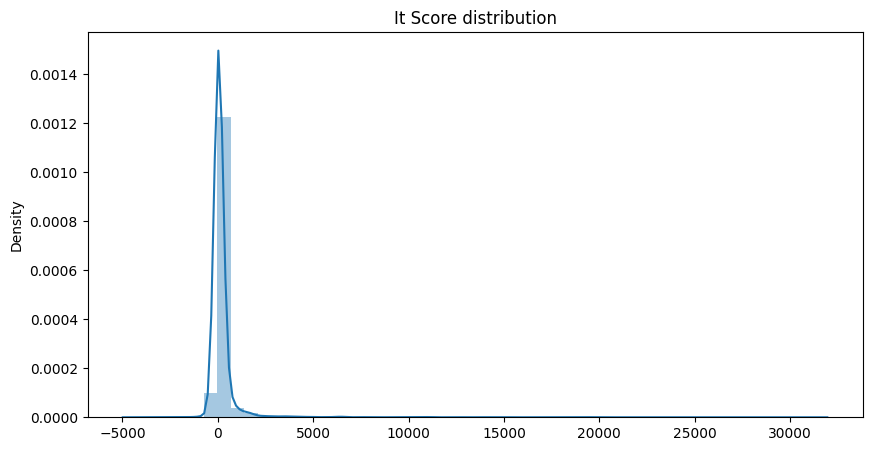

<Figure size 640x480 with 0 Axes>

In [201]:
fig = plt.figure(figsize=(10,5))
sns.distplot(list(it_score.values()))
plt.title("It Score distribution")
plt.figure()

<ipython-input-202-850591aa6c6f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(it_score_nor.values()))


<Figure size 640x480 with 0 Axes>

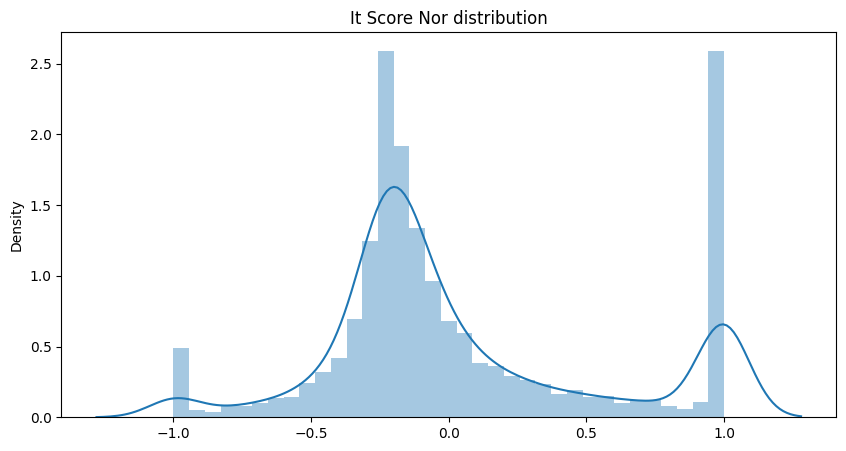

<Figure size 640x480 with 0 Axes>

In [202]:
fig = plt.figure(figsize=(10,5))
sns.distplot(list(it_score_nor.values()))
plt.title("It Score Nor distribution")
plt.figure()

<Figure size 640x480 with 0 Axes>

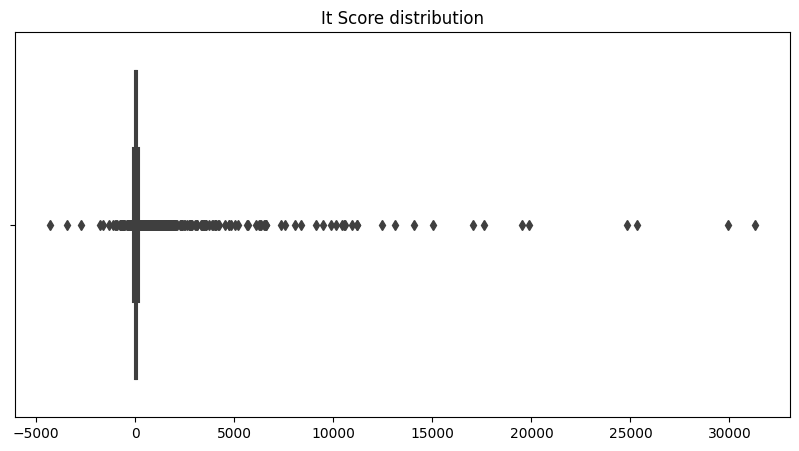

<Figure size 640x480 with 0 Axes>

In [203]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=list(it_score.values()))
plt.title("It Score distribution")
plt.figure()

# Hybrid Approach

In [204]:
score_dict = {key: 0 for key in filter_words}
for word in filter_words:
  score_dict[word] = (p_score_nor[word] + it_score_nor[word])/2

In [205]:
print(sorted(score_dict.items(), key=lambda item: item[1], reverse=False))

[('최악/NNG', -1.0), ('욕먹/VV', -0.8682950191570882), ('통보/NNG', -0.8197956577266923), ('장사/NNG', -0.8015030946065429), ('도저히/MAG', -0.7898005020478267), ('물탄/NNP', -0.768558429118774), ('반품/NNG', -0.7464010713090057), ('이하/NNG', -0.7385339193148523), ('별로/NNG', -0.7375478927203065), ('환불/NNG', -0.7359386973180077), ('검수/NNG', -0.7308429118773947), ('황당/XR', -0.7227969348659005), ('질질/MAG', -0.7144529587058324), ('불친절/NNG', -0.7134099616858238), ('허접/NNG', -0.6689791643941443), ('방치/NNG', -0.657088122605364), ('식초/NNG', -0.6452873563218391), ('번호/NNG', -0.6150464358991908), ('차라리/MAG', -0.6101532567049808), ('그냥저냥/MAG', -0.6058864507140369), ('엉망/NNG', -0.605683269476373), ('그런대로/MAG', -0.5945083014048532), ('실망/NNG', -0.5936174854447036), ('허접/XR', -0.5776598880047157), ('지원/NNG', -0.5736483610046827), ('닝닝/MAG', -0.573253843154045), ('청소/NNG', -0.5656828283623951), ('지극히/MAG', -0.5637465951821774), ('기대치/NNG', -0.558337638654234), ('비추/NNG', -0.551840241495414), ('민망/XR', -0.54923779245

In [208]:
# Save score dictionary
with open("score_dict.pkl", "wb") as f:
    pickle.dump(score_dict, f)

## Visualization

<ipython-input-209-3eb65b090daa>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(score_dict.values()))


<Figure size 640x480 with 0 Axes>

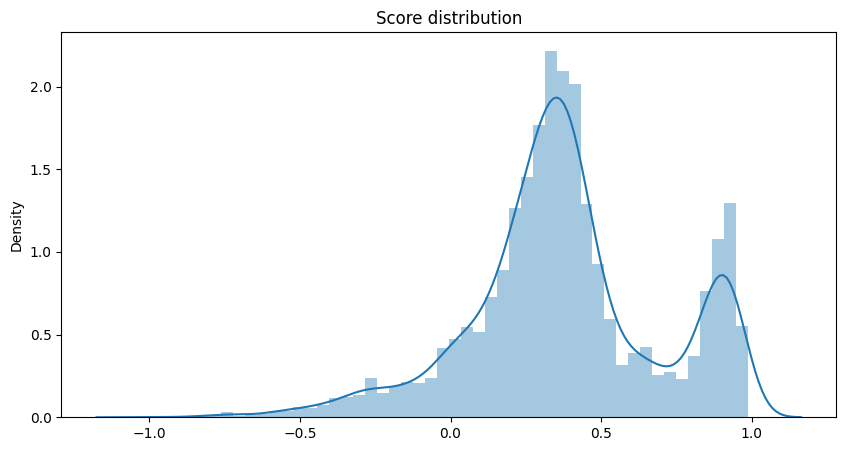

<Figure size 640x480 with 0 Axes>

In [209]:
fig = plt.figure(figsize=(10,5))
sns.distplot(list(score_dict.values()))
plt.title("Score distribution")
plt.figure()